# P3HT 

### Imports and functions

In [12]:
import cmeutils
from cmeutils.structure import gsd_rdf, get_quaternions, diffraction_pattern,all_atom_rdf #, k_vector_to_length #, bragg_angle_to_length
import freud
from freud.diffraction import DiffractionPattern, StaticStructureFactorDirect
import gsd.hoomd
import numpy as np
import matplotlib.pyplot as plt
import signac
import os

# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 1
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.marker"] = "o"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200

def snapshot_to_freud(snapshot, ref_distance):
    box = snapshot.configuration.box
    box[0:3] *= ref_distance
    xyz = snapshot.particles.position * ref_distance
    return freud.locality.NeighborQuery.from_system(system=(box, xyz))

In [3]:
project = signac.get_project()
project

,sp.density,sp.n_compounds,sp.system_kwargs,sp.remove_hydrogens,sp.remove_charges,sp.tau_kt,sp.dt,sp.r_cut,sp.sim_seed,sp.shrink_steps,...,sp.kT,sp.n_steps,doc.done,doc.equilibrated,doc.run,doc.ref_distance,doc.ref_mass,doc.ref_energy,doc.target_box,doc.order
183d6175a34e38ce9a178495056440e9,0.25,100,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,0.48,1000000.0,False,True,13,3.563595,5.323688e-26,0.25,"[33.21318920826215, 33.21318920826215, 33.2131...",None
61b579e90a9727fd7b18c558beec0641,0.25,100,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,2.42,1000000.0,False,True,11,3.563595,5.323688e-26,0.25,"[33.21318920826215, 33.21318920826215, 33.2131...",None
090898d3c06ea38cc3309a20307b469d,0.25,100,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,3.40,1000000.0,False,True,6,3.563595,5.323688e-26,0.25,"[33.21318920826215, 33.21318920826215, 33.2131...",None
03530b55f6265c16b8cef902a0224804,0.25,100,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,4.84,1000000.0,False,True,6,3.563595,5.323688e-26,0.25,"[33.21318920826215, 33.21318920826215, 33.2131...",None
d5c33f861eee1d39608954e5cd7a3c56,0.50,100,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,0.48,1000000.0,False,True,12,3.563595,5.323688e-26,0.25,"[26.361325744207097, 26.361325744207097, 26.36...",None
1328180e5651bdc0c5a3779da737f421,0.50,100,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,2.42,1000000.0,False,True,14,3.563595,5.323688e-26,0.25,"[26.361325744207097, 26.361325744207097, 26.36...",None
8e0639722c548a52e54e65eeb4c07a07,0.50,100,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,3.40,1000000.0,False,True,11,3.563595,5.323688e-26,0.25,"[26.361325744207097, 26.361325744207097, 26.36...",None
70290268102eb3fb4d08f6ae6c55857a,0.50,100,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,4.84,1000000.0,False,True,5,3.563595,5.323688e-26,0.25,"[26.361325744207097, 26.361325744207097, 26.36...",None
9dc732f35308b34e799a42de536f2bd6,1.00,100,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,0.48,1000000.0,False,True,12,3.563595,5.323688e-26,0.25,"[20.92299810881536, 20.92299810881536, 20.9229...",None
f3e786c4dc7d9faab6bb295966ada6f0,1.00,100,None,True,True,0.01,0.0001,2.5,42,5000000.0,...,2.42,1000000.0,False,True,14,3.563595,5.323688e-26,0.25,"[20.92299810881536, 20.92299810881536, 20.9229...",None


## RDF Calculations

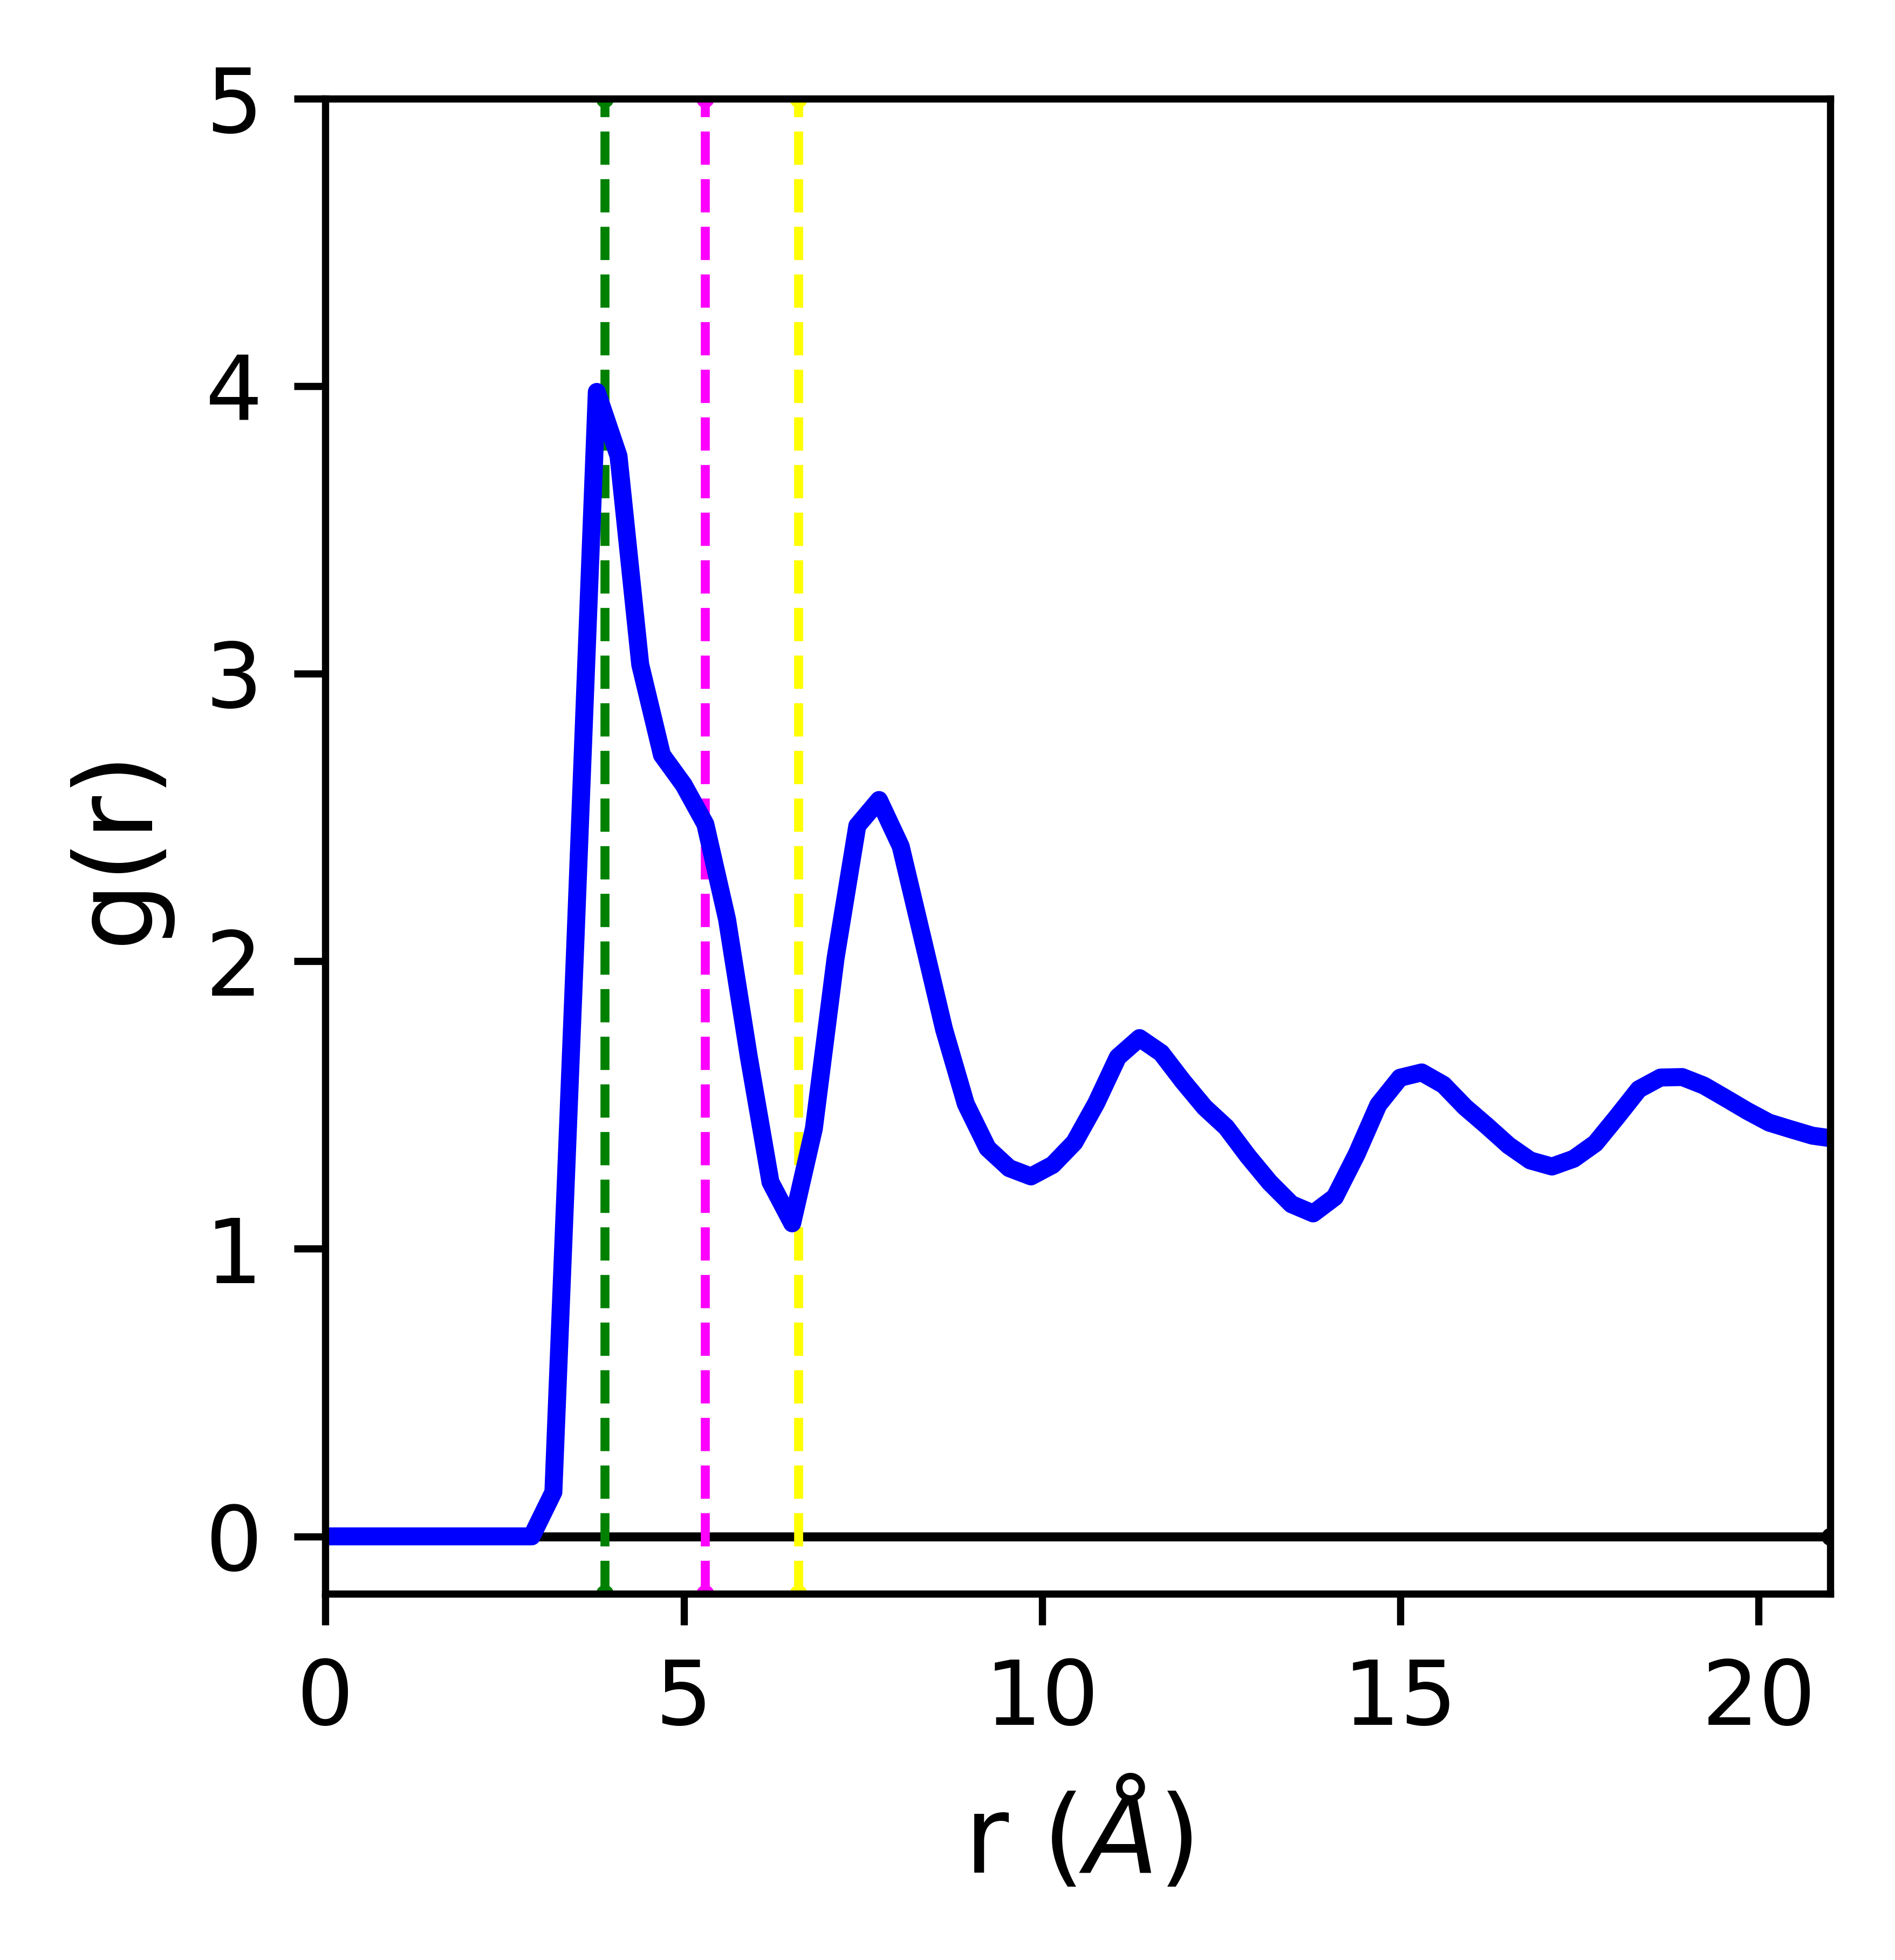

In [10]:
for job in project.find_jobs({'density':0.5,'kT':2.42}):
    if job.doc.equilibrated == True:
        if os.path.isfile(job.fn('cg_traj.gsd')):
            with gsd.hoomd.open(job.fn('cg_traj.gsd'),mode='r') as trajectory:
                snap = trajectory[-1]
            rdf, N = gsd_rdf(
                gsdfile= job.fn('cg_traj.gsd'),
                A_name='S2',
                B_name='S2',
                start=-100,
                stop=-1,
                r_max=8.5,
                exclude_bonded=True
            )
        plt.axhline(y = 0, color ="black", linestyle ="-") 
        plt.axvline(x = 3.9, color = 'green',linestyle='--')
        plt.axvline(x = 5.3, color = 'magenta',linestyle='--')
        plt.axvline(x = 6.6, color = 'yellow',linestyle='--')
        plt.plot(rdf.bin_centers*job.doc.ref_distance, rdf.rdf*N,'b',marker='None',linestyle="-",linewidth=2)

plt.xlabel("r ($\AA$)")
plt.ylabel("g(r)")
plt.xlim(0,21)
plt.yticks(np.arange(0,6,1))
plt.xticks(np.arange(0,21,5))
fig = plt
plt.savefig(fname = "order_parameter.png")

## Diffraction Pattern

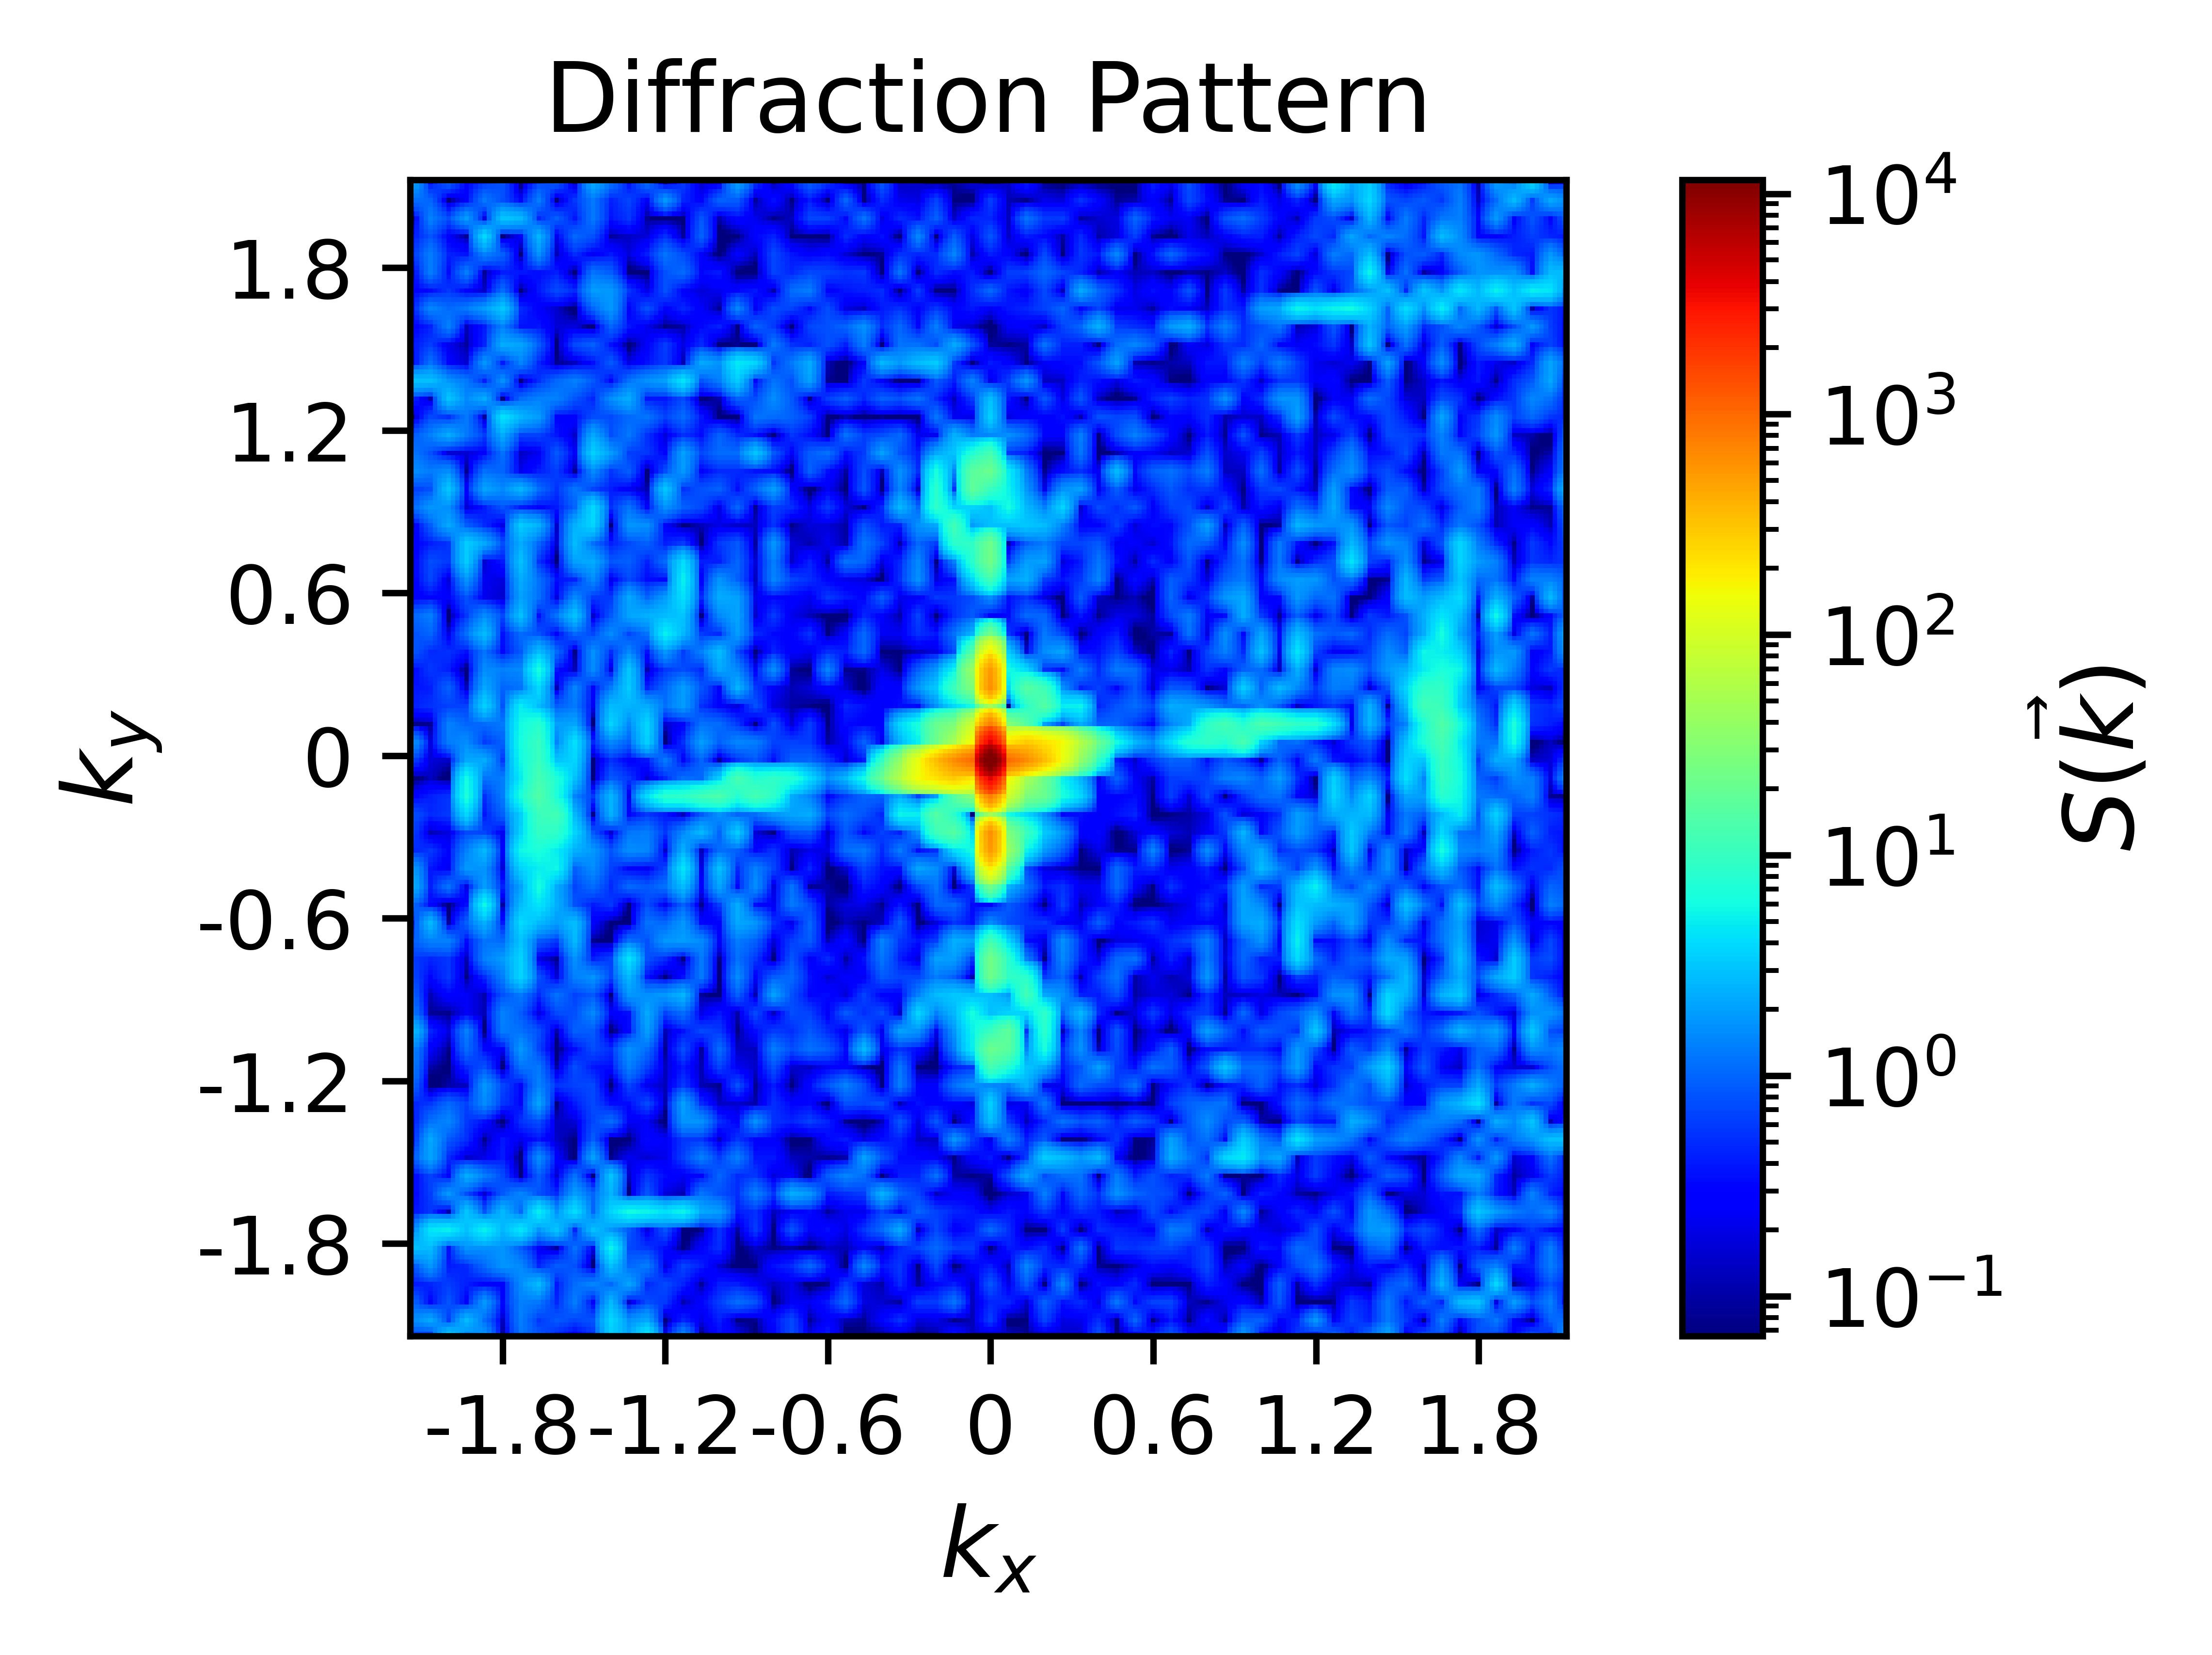

In [11]:
for job in project.find_jobs({"density":0.5,"kT":2.42}):
    snap = gsd.hoomd.open(job.fn(f"trajectory{job.doc.run}.gsd"))[-1]
    system = snapshot_to_freud(snap, job.doc.ref_distance)

    dp = DiffractionPattern(grid_size=256)
    dp.compute(system=system, view_orientation=[6.123234e-17, 0, 0, 1], reset=False)
    dp.plot(cmap="jet")